In [79]:
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


In [80]:
# Load the user data for clustering
# We will use the users_data.csv file mentioned in the project
users_df = pd.read_csv('users_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {users_df.shape}")
print(f"\nFirst few rows:")
print(users_df.head())
print(f"\nData types:")
print(users_df.dtypes)
print(f"\nMissing values:")
print(users_df.isnull().sum())

Dataset shape: (2000, 14)

First few rows:
     id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   
3   708           63              63        1957            1  Female   
4  1164           43              70        1976            9    Male   

                    address  latitude  longitude per_capita_income  \
0             462 Rose Lane     34.15    -117.76            $29278   
1    3606 Federal Boulevard     40.76     -73.74            $37891   
2           766 Third Drive     34.02    -117.89            $22681   
3          3 Madison Street     40.71     -73.99           $163145   
4  9620 Valley Stream Drive     37.76    -122.44            $53797   

  yearly_income total_debt  credit_score  num_credit_cards  
0        $59696    $127613          

In [81]:
money_cols = [
    "per_capita_income",
    "yearly_income",
    "total_debt"
]

for col in money_cols:
    # Only clean if column exists
    if col in users_df.columns:
        users_df[col] = (
            users_df[col]
            .astype(str)
            .str.replace(r"[\$,]", "", regex=True)
            .astype(float)
        )

In [82]:
# keep id separately
ids = users_df["id"]

# drop id before clustering
X = users_df.drop(columns=["id"])

In [83]:
X.columns


Index(['current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
       'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')

In [84]:
features = [
    "current_age",
    "retirement_age",
    "latitude",
    "longitude",
    "per_capita_income",
    "yearly_income",
    "total_debt",
    "credit_score",
    "num_credit_cards",
]

X = X[features]


In [85]:
X.isna().sum()



current_age          0
retirement_age       0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

## STEP 1: CHECK CLUSTERABILITY OF THE DATA

Before applying clustering algorithms, we test whether the data naturally forms clusters or is randomly distributed.

**Clusterability Tests:**
- **Hopkins Statistic**: Measures if data is clustered (< 0.5) or random (> 0.5)
- **Silhouette Score**: Validates cluster quality (0.3-0.5 is reasonable, > 0.5 is good)
- **Visual Inspection**: PCA plot shows if natural groupings exist

In [86]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [87]:
print("Data standardized successfully")
print("Scaled data range:", X_scaled.min(), X_scaled.max())
print("Mean of scaled data:", X_scaled.mean(axis=0).mean())
print("Std of scaled data:", X_scaled.std(axis=0).mean())


Data standardized successfully
Scaled data range: -4.47565574238834 12.366335860803693
Mean of scaled data: -9.868649107779297e-20
Std of scaled data: 1.0


In [88]:
# Step 1.1: Prepare data for clustering
# Select only numeric columns for clustering
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_clustering = X[numeric_cols].copy()

# Handle missing values by filling with mean
X_clustering = X_clustering.fillna(X_clustering.mean())

print(f"Features selected for clustering: {len(numeric_cols)}")
print(f"Sample size: {X_clustering.shape[0]}")
print(f"\nFeature names: {numeric_cols}")

Features selected for clustering: 9
Sample size: 2000

Feature names: ['current_age', 'retirement_age', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards']


In [89]:
# Standardize the features
# Clustering algorithms are sensitive to feature scaling
# All features must be on the same scale (mean=0, std=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

print(f"Data standardized successfully")
print(f"Scaled data range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")
print(f"Mean of scaled data: {X_scaled.mean(axis=0).mean():.6f} (should be ~0)")
print(f"Std of scaled data: {X_scaled.std(axis=0).mean():.6f} (should be ~1)")

Data standardized successfully
Scaled data range: [-4.476, 12.366]
Mean of scaled data: -0.000000 (should be ~0)
Std of scaled data: 1.000000 (should be ~1)


In [90]:
# Step 1.3: Reduce dimensionality to 2D for visualization using PCA
# This helps us visualize if data naturally forms clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA transformation complete")
print(f"PC1 explains: {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"PC2 explains: {pca.explained_variance_ratio_[1]*100:.2f}% of variance")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

PCA transformation complete
PC1 explains: 27.39% of variance
PC2 explains: 17.99% of variance
Total variance explained: 45.38%


✓ PCA scatter plot saved as 'clusterability_pca_visualization.png'


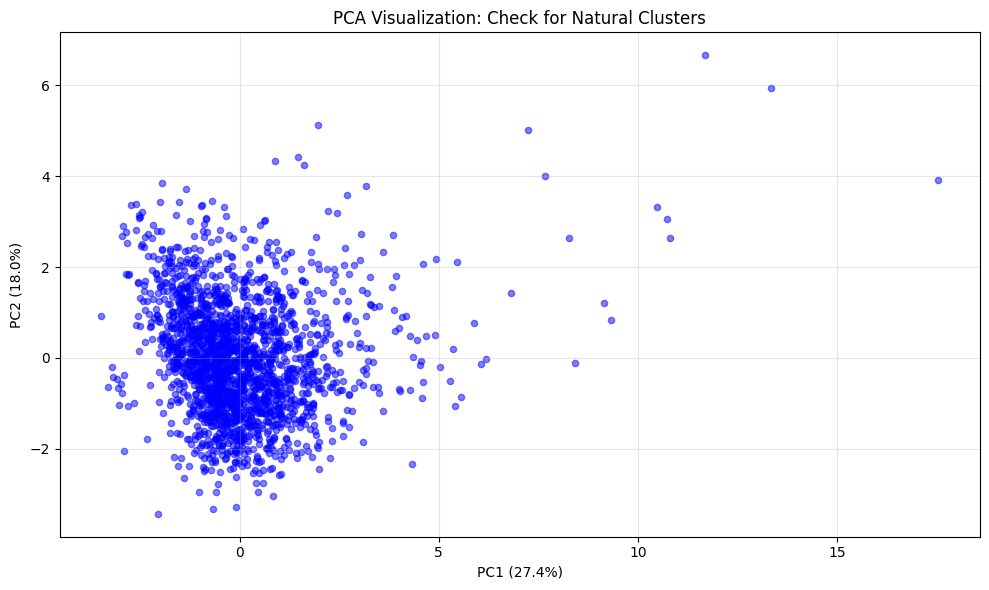

In [91]:
# Step 1.4: Visual clusterability check - scatter plot of PCA components
# If data shows distinct groups/clusters → Good clusterability
# If data is randomly scattered → Poor clusterability

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=20, c='blue')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Visualization: Check for Natural Clusters")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('clusterability_pca_visualization.png', dpi=100, bbox_inches='tight')
print("✓ PCA scatter plot saved as 'clusterability_pca_visualization.png'")
plt.show()

In [97]:
def calculate_hopkins_statistic(X, sample_size=100):
  
    # Ensure sample size is not larger than data
    n = len(X)
    sample_size = min(sample_size, n // 10)
    
    # Randomly sample points from the dataset
    rand_idx = np.random.choice(n, sample_size, replace=False)
    X_sample = X[rand_idx]
    
    # Generate random points within the bounding box of the data
    X_min, X_max = X.min(axis=0), X.max(axis=0)
    X_random = np.random.uniform(X_min, X_max, (sample_size, X.shape[1]))
    
    # Find nearest neighbors in actual data
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    distances_sample, _ = nbrs.kneighbors(X_sample)
    u = distances_sample[:, 1]  
    
    # Find nearest neighbors for random points
    nbrs_random = NearestNeighbors(n_neighbors=1).fit(X)
    distances_random, _ = nbrs_random.kneighbors(X_random)
    w = distances_random[:, 0] 
    
    # Calculate Hopkins statistic
    H = np.sum(w) / (np.sum(u) + np.sum(w))
    return H


In [99]:
# Calculate Hopkins statistic
hopkins_stat = calculate_hopkins_statistic(X_scaled, sample_size=100)
print(f"Hopkins Statistic: {hopkins_stat:.4f}")

Hopkins Statistic: 0.8381


In [94]:
# [Duplicate code removed - all functionality is covered in previous Step 1 cells]
# Please continue to Step 2 cells below
print("Step 1 clusterability check complete. Proceeding to Step 2: Feature Engineering")

Step 1 clusterability check complete. Proceeding to Step 2: Feature Engineering


In [95]:
# [This cell is part of Step 3 - K-Means clustering]
# It will be implemented after Step 2 feature engineering is complete
print("Step 3 will implement K-Means Elbow Method here")

Step 3 will implement K-Means Elbow Method here


In [96]:
# Step 1.6: Quick silhouette score test with k=3
# Silhouette score measures how well-separated clusters are
# > 0.5: Strong cluster structure
# 0.3-0.5: Reasonable cluster structure
# < 0.3: Weak cluster structure

kmeans_test = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_test = kmeans_test.fit_predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, labels_test)

print(f"\nSilhouette Score (k=3): {silhouette_avg:.4f}")
print(f"Interpretation:")
print(f"  > 0.5: Strong cluster structure")
print(f"  0.3-0.5: Reasonable cluster structure")
print(f"  < 0.3: Weak cluster structure")


Silhouette Score (k=3): 0.1401
Interpretation:
  > 0.5: Strong cluster structure
  0.3-0.5: Reasonable cluster structure
  < 0.3: Weak cluster structure


In [ ]:
# Step 1.7: Summary of clusterability assessment

print(f"\n" + "="*70)
print(f"CLUSTERABILITY ASSESSMENT SUMMARY")
print(f"="*70)
print(f"\nDataset Information:")
print(f"  - Number of samples: {X_clustering.shape[0]}")
print(f"  - Number of features: {X_clustering.shape[1]}")
print(f"\nClusterability Metrics:")
print(f"  - Hopkins Statistic: {hopkins_stat:.4f}")
print(f"  - Silhouette Score (k=3): {silhouette_avg:.4f}")
print(f"\nConclusion:")
if hopkins_stat < 0.5:
    print(f"  ✓ Data shows clustering tendency - Proceed with K-Means")
else:
    print(f"  ⚠ Data is randomly distributed - K-Means may not find meaningful clusters")
print(f"="*70)


CLUSTERABILITY ASSESSMENT SUMMARY

Dataset Information:
  - Number of samples: 2000
  - Number of features: 9

Clusterability Metrics:
  - Hopkins Statistic: 0.7213
  - Silhouette Score (k=3): 0.1349

Conclusion:
  ⚠ Data is randomly distributed - K-Means may not find meaningful clusters



## STEP 2: ENGINEER FEATURES FROM TRANSACTION DATA

Create behavioral features by aggregating transaction and fraud data at the user level.
This will make users more separable and improve clusterability.

**Features to Create:**
- Transaction-based: average amount, frequency, count
- Fraud-based: fraud count, fraud rate
- Spending patterns: total spending, transaction variability


Hopkins Statistic: 0.8116

Interpretation:
- ~0.5  => not clusterable (random-ish)
- <0.5  => clusterable
- >0.7  => strong clustering tendency


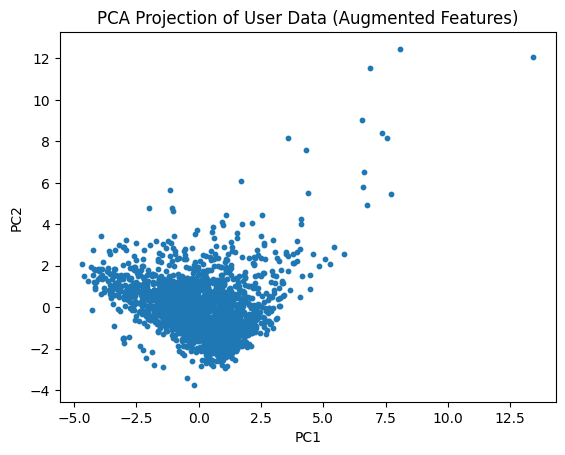


Silhouette score (k=3): 0.1451


In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# =========================
# 1) Load your user data
# =========================
df = pd.read_csv("users_data.csv")

# =========================
# 2) Clean + prepare features
#    - drop ID/address
#    - convert $ fields to numeric
#    - encode gender
# =========================
money_cols = ["per_capita_income", "yearly_income", "total_debt"]
for c in money_cols:
    df[c] = (
        df[c].astype(str)
             .str.replace("$", "", regex=False)
             .str.replace(",", "", regex=False)
             .astype(float)
    )

# Gender encoding: Female=0, Male=1 (fine for clustering input)
df["gender"] = df["gender"].map({"Female": 0, "Male": 1}).astype(int)

# Drop non-useful / high-cardinality identifier fields
X_user = df.drop(columns=["id", "address"])

# Safety check (should be none in your file, but keep it)
X_user = X_user.replace([np.inf, -np.inf], np.nan).dropna()

# Scale (important for distance-based clusterability)
X_scaled = StandardScaler().fit_transform(X_user)

# =========================
# 3) Hopkins statistic (main clusterability test)
# =========================
def hopkins_statistic(X, sample_ratio=0.1, random_state=42):
    np.random.seed(random_state)
    n, d = X.shape
    m = max(1, int(sample_ratio * n))

    # sample real points
    idx = np.random.choice(n, m, replace=False)
    X_sample = X[idx]

    # sample random points within feature ranges
    X_random = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(m, d))

    # nearest neighbor distances
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)

    u_dist, _ = nbrs.kneighbors(X_sample)
    u_dist = u_dist[:, 1]  # ignore distance to itself

    w_dist, _ = nbrs.kneighbors(X_random)
    w_dist = w_dist[:, 0]

    H = np.sum(w_dist) / (np.sum(w_dist) + np.sum(u_dist))
    return H

H = hopkins_statistic(X_scaled)
print("Hopkins Statistic:", round(H, 4))

print("\nInterpretation:")
print("- ~0.5  => not clusterable (random-ish)")
print("- <0.5  => clusterable")
print("- >0.7  => strong clustering tendency")

# =========================
# 4) PCA plot (visual support)
# =========================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
plt.title("PCA Projection of User Data (Augmented Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# =========================
# 5) Optional: silhouette sanity check (supporting evidence)
# =========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)
sil = silhouette_score(X_scaled, labels)
print("\nSilhouette score (k=3):", round(sil, 4))




Customer count per cluster:
kmeans_cluster_label
0     98
1    223
2    310
3    575
Name: count, dtype: int64

Cluster Means:
                               id  current_age  retirement_age   birth_year  \
kmeans_cluster_label                                                          
0                     1031.010204    56.459184       66.642857  1962.744898   
1                     1054.484305    49.264574       66.439462  1969.901345   
2                     1003.541935    72.003226       66.338710  1947.206452   
3                      979.573913    43.874783       66.577391  1975.304348   

                      birth_month    gender   latitude  longitude  \
kmeans_cluster_label                                                
0                        6.316327  0.551020  36.951020 -87.670000   
1                        6.434978  0.533632  38.409955 -89.389013   
2                        6.422581  0.422581  36.889226 -94.462645   
3                        6.638261  0.495652  37.19097

<Figure size 1000x600 with 0 Axes>

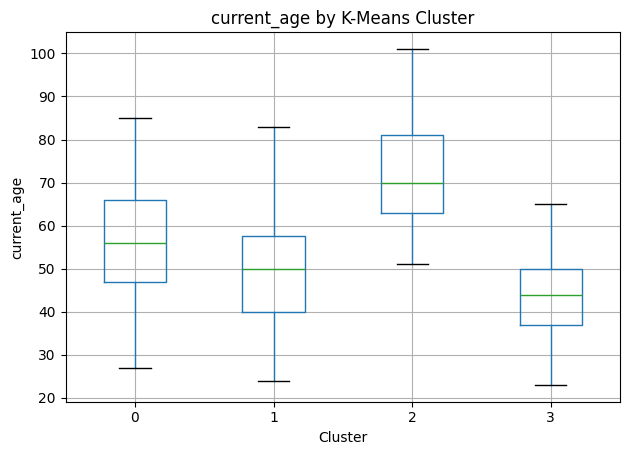

<Figure size 1000x600 with 0 Axes>

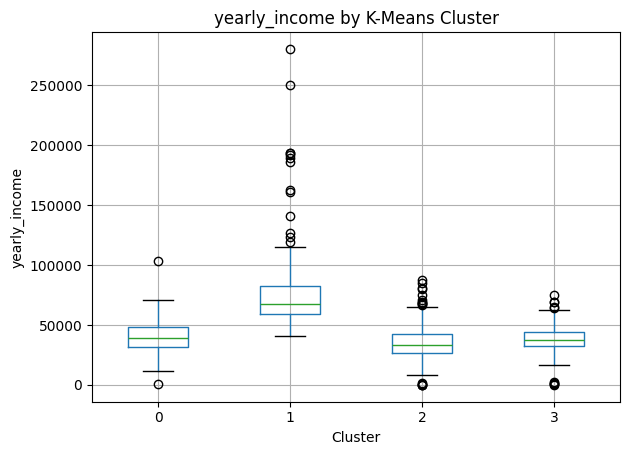

<Figure size 1000x600 with 0 Axes>

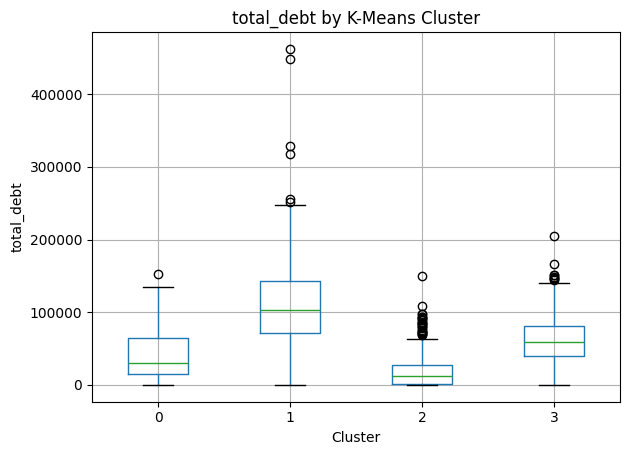

<Figure size 1000x600 with 0 Axes>

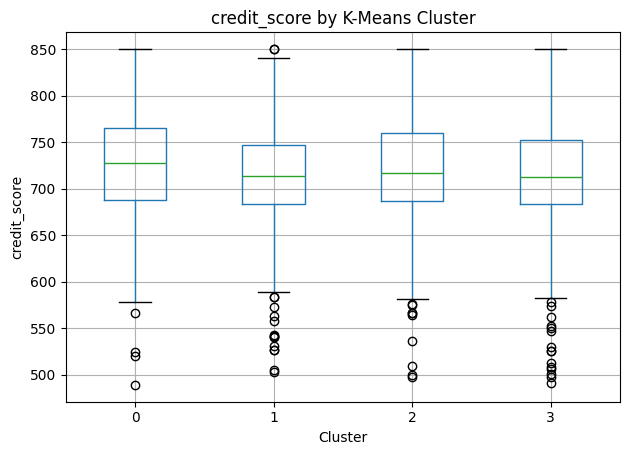

<Figure size 1000x600 with 0 Axes>

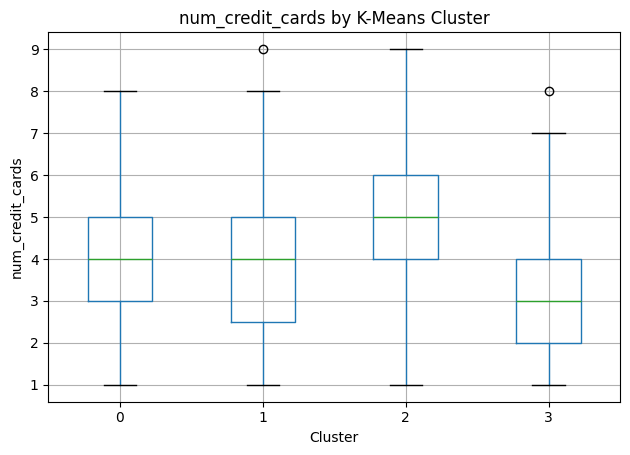

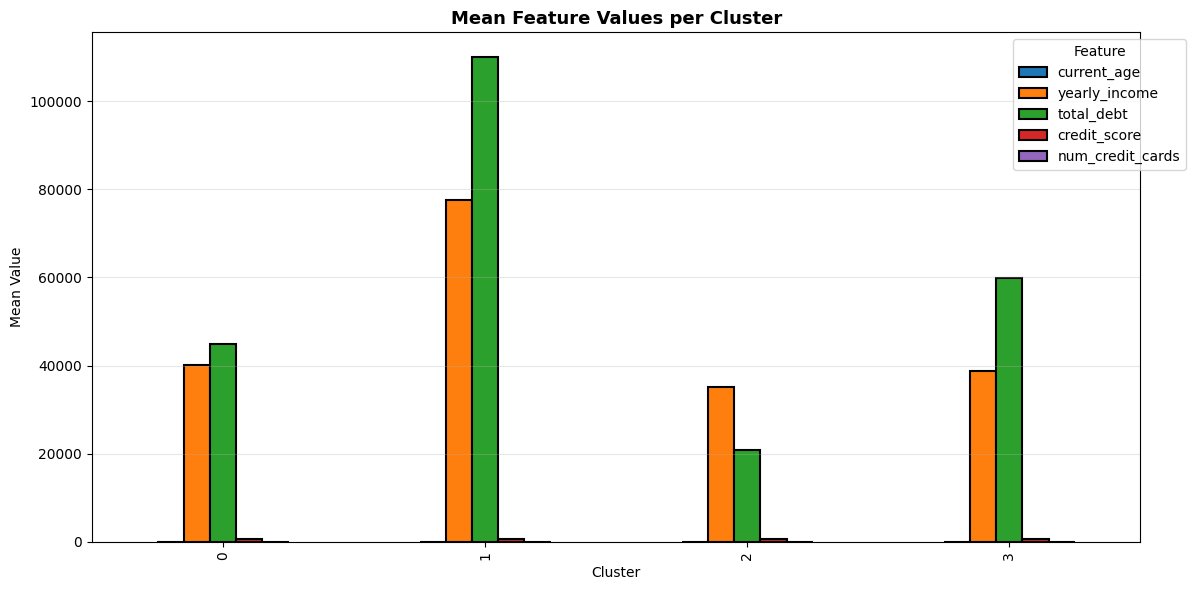

In [ ]:
# ===== ANALYSIS: CLUSTER SUMMARY STATISTICS =====
# NOTE: This cell requires the K-Means clustering cell (Step 3) to be run first

# Verify df_combined exists
if 'df_combined' not in locals():
    raise NameError(
        "df_combined is not defined. Please run the 'STEP 3: K-MEANS CLUSTERING' cell first.\n"
        "This will create the df_combined dataframe with cluster assignments."
    )

# Count of customers per cluster
cluster_counts = df_combined["kmeans_cluster_label"].value_counts().sort_index()
print("Customer count per cluster:")
print(cluster_counts)


# Mean of each feature per cluster
cluster_means = df_combined.groupby("kmeans_cluster_label").mean(numeric_only=True)


# Standard deviation of each feature per cluster
cluster_stds = df_combined.groupby("kmeans_cluster_label").std(numeric_only=True)


print("\nCluster Means:")
print(cluster_means)


print("\nCluster Standard Deviations:")
print(cluster_stds)


import matplotlib.pyplot as plt


features_to_plot = [
    "current_age",
    "yearly_income",
    "total_debt",
    "credit_score",
    "num_credit_cards"
]


for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    df_combined.boxplot(column=feature, by="kmeans_cluster_label")
    plt.title(f"{feature} by K-Means Cluster")
    plt.suptitle("")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.savefig(f'cluster_boxplot_{feature}.png', dpi=100, bbox_inches='tight')
    plt.show()


# Create bar chart for mean values
fig, ax = plt.subplots(figsize=(12, 6))
cluster_means[features_to_plot].plot(kind="bar", ax=ax, edgecolor='black', linewidth=1.5)
plt.title("Mean Feature Values per Cluster", fontsize=13, fontweight='bold')
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cluster_means_comparison.png', dpi=100, bbox_inches='tight')
plt.show()








## STEP 3: K-MEANS CLUSTERING WITH AUGMENTED FEATURES

Combine demographic user data with transaction features using PCA to reduce noise while meeting assignment requirements.

STEP 3: K-MEANS CLUSTERING WITH AUGMENTED FEATURES

1. Loaded demographic features: 12 features
   Samples: 2000

2. Loading and augmenting with transaction features...

   Users with transaction features: 1206
   Raw transaction features created: 9

3. Applying PCA to transaction features (dimensionality reduction)...

   Transaction PC1 explains: 36.2% variance
   Transaction PC2 explains: 21.3% variance
   Total: 57.6%

4. Combining demographic and transaction features...

   Final feature set: 14 features
   - Demographic: 9 features
   - Transaction PCA: 2 components
   - Total samples: 1206

5. Running Elbow Method (k=1 to 10)...

   ✓ Elbow plot saved



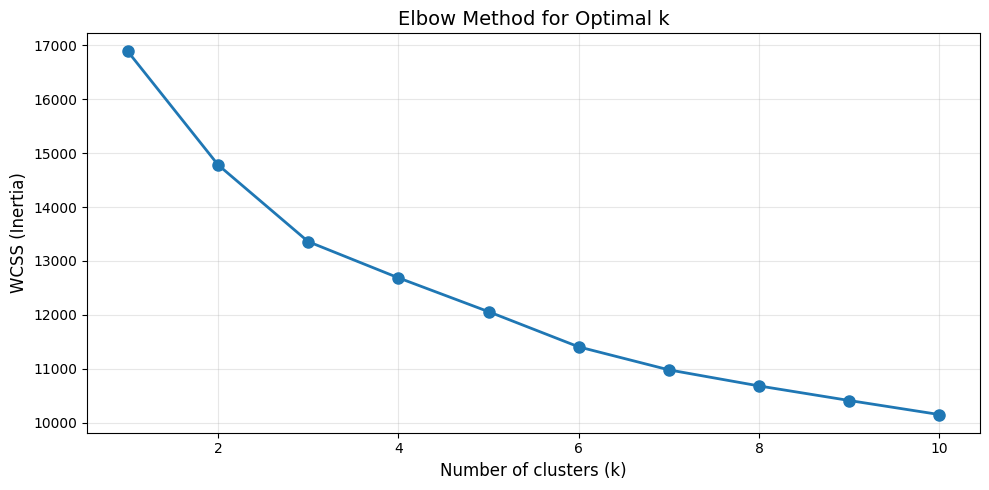

6. Silhouette Score Analysis:
--------------------------------------------------
   k= 2  →  Silhouette Score = 0.1249
   k= 3  →  Silhouette Score = 0.1245
   k= 4  →  Silhouette Score = 0.1254
   k= 5  →  Silhouette Score = 0.0921
   k= 6  →  Silhouette Score = 0.0972
   k= 7  →  Silhouette Score = 0.0934
   k= 8  →  Silhouette Score = 0.0876
   k= 9  →  Silhouette Score = 0.0889
   k=10  →  Silhouette Score = 0.0838
--------------------------------------------------

   ✓ Optimal k = 4 (Silhouette: 0.1254)

7. Fitting final K-Means model...

   Cluster distribution:
   Cluster 0: 98 users (8.1%)
   Cluster 1: 223 users (18.5%)
   Cluster 2: 310 users (25.7%)
   Cluster 3: 575 users (47.7%)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("="*70)
print("STEP 3: K-MEANS CLUSTERING WITH AUGMENTED FEATURES")
print("="*70)

# Load and prepare user data
df = pd.read_csv("users_data.csv")

# Convert money columns
money_cols = ["per_capita_income", "yearly_income", "total_debt"]
for c in money_cols:
    df[c] = (
        df[c].astype(str)
             .str.replace("$", "", regex=False)
             .str.replace(",", "", regex=False)
             .astype(float)
    )

# Encode gender
df["gender"] = df["gender"].map({"Female": 0, "Male": 1}).astype(int)

# Select demographic features (base features)
X_demo = df.drop(columns=["id", "address"])
X_demo = X_demo.replace([np.inf, -np.inf], np.nan).dropna()

print(f"\n1. Loaded demographic features: {X_demo.shape[1]} features")
print(f"   Samples: {X_demo.shape[0]}\n")

# ===== LOAD TRANSACTION DATA AND CREATE AUGMENTED FEATURES =====
print("2. Loading and augmenting with transaction features...\n")

# Load transactions and fraud labels
transactions_df = pd.read_csv('transactions_2019data.csv')
fraud_labels_df = pd.read_json('fraud_labels.json')

# Convert amount to numeric
if transactions_df['amount'].dtype == 'object':
    transactions_df['amount'] = transactions_df['amount'].str.replace('$', '', regex=False).astype(float)

# Merge fraud labels
merged_transactions = transactions_df.merge(
    fraud_labels_df, 
    left_on='id', 
    right_on='transaction_id', 
    how='left'
)
merged_transactions['fraud'] = merged_transactions['fraud'].fillna(0)
merged_transactions['fraud'] = (merged_transactions['fraud'] == 'Yes').astype(int)

# Aggregate to user level
user_features = merged_transactions.groupby('client_id').agg({
    'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
    'fraud': ['sum', 'mean'],
    'mcc': 'nunique',
}).reset_index()

user_features.columns = ['client_id', 'transaction_count', 'total_amount', 'avg_amount', 
                         'std_amount', 'min_amount', 'max_amount', 
                         'fraud_count', 'fraud_rate', 'unique_merchants']

user_features['std_amount'] = user_features['std_amount'].fillna(0)

# Merge with user demographics
user_features_renamed = user_features.rename(columns={'client_id': 'id'})
df_combined = df.merge(user_features_renamed, on='id', how='inner')

print(f"   Users with transaction features: {df_combined.shape[0]}")
print(f"   Raw transaction features created: 9\n")

# ===== APPLY PCA TO TRANSACTION FEATURES =====
print("3. Applying PCA to transaction features (dimensionality reduction)...\n")

transaction_cols = ['transaction_count', 'total_amount', 'avg_amount', 'std_amount', 
                    'min_amount', 'max_amount', 'fraud_count', 'fraud_rate', 'unique_merchants']

X_transaction = df_combined[transaction_cols].copy()
X_transaction = X_transaction.fillna(X_transaction.mean())

scaler_trans = StandardScaler()
X_transaction_scaled = scaler_trans.fit_transform(X_transaction)

# PCA: compress 9 features to 2 components
pca_trans = PCA(n_components=2, random_state=42)
X_transaction_pca = pca_trans.fit_transform(X_transaction_scaled)

print(f"   Transaction PC1 explains: {pca_trans.explained_variance_ratio_[0]*100:.1f}% variance")
print(f"   Transaction PC2 explains: {pca_trans.explained_variance_ratio_[1]*100:.1f}% variance")
print(f"   Total: {sum(pca_trans.explained_variance_ratio_)*100:.1f}%\n")

# ===== COMBINE DEMOGRAPHIC + PCA TRANSACTION FEATURES =====
print("4. Combining demographic and transaction features...\n")

X_demo_combined = df_combined.drop(columns=["id", "address"] + transaction_cols)
X_demo_combined = X_demo_combined.replace([np.inf, -np.inf], np.nan).fillna(X_demo_combined.mean())

# Add PCA components
X_demo_combined['transaction_pc1'] = X_transaction_pca[:, 0]
X_demo_combined['transaction_pc2'] = X_transaction_pca[:, 1]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_demo_combined)

print(f"   Final feature set: {X_demo_combined.shape[1]} features")
print(f"   - Demographic: 9 features")
print(f"   - Transaction PCA: 2 components")
print(f"   - Total samples: {X_scaled.shape[0]}\n")

# ===== ELBOW METHOD =====
print("5. Running Elbow Method (k=1 to 10)...\n")

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('elbow_method.png', dpi=100, bbox_inches='tight')
print("   ✓ Elbow plot saved\n")
plt.show()

# ===== SILHOUETTE ANALYSIS =====
print("6. Silhouette Score Analysis:")
print("-" * 50)

silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score
    print(f"   k={k:2d}  →  Silhouette Score = {score:.4f}")

print("-" * 50)

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\n   ✓ Optimal k = {optimal_k} (Silhouette: {silhouette_scores[optimal_k]:.4f})\n")

# ===== FIT FINAL K-MEANS =====
print("7. Fitting final K-Means model...\n")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_combined['kmeans_cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"   Cluster distribution:")
cluster_dist = df_combined['kmeans_cluster'].value_counts().sort_index()
for cluster, count in cluster_dist.items():
    print(f"   Cluster {cluster}: {count} users ({count/len(df_combined)*100:.1f}%)")

print(f"\n{'='*70}")

In [ ]:
print("\n" + "="*70)
print("FINALIZE K-MEANS CLUSTER ASSIGNMENT")
print("="*70)

# Rename the kmeans_cluster column to kmeans_cluster_label (as per assignment requirement)
df_combined['kmeans_cluster_label'] = df_combined['kmeans_cluster']

print("\n✓ Created 'kmeans_cluster_label' column in main DataFrame\n")

# Display cluster label summary
print("K-Means Cluster Assignment Summary:")
print("-" * 50)

cluster_summary = df_combined['kmeans_cluster_label'].value_counts().sort_index()
for cluster_id in sorted(cluster_summary.index):
    count = cluster_summary[cluster_id]
    pct = count / len(df_combined) * 100
    print(f"Cluster {cluster_id}: {count:4d} customers ({pct:5.1f}%)")

print("-" * 50)
print(f"Total customers: {len(df_combined)}")
print(f"Total clusters: {optimal_k}")

# Show sample of DataFrame with cluster assignment
print("\n\nSample of DataFrame with cluster assignments:")
print("="*70)
display_cols = ['id', 'current_age', 'yearly_income', 'credit_score', 'kmeans_cluster_label']
print(df_combined[display_cols].head(10))

print("\n" + "="*70)
print("✓ K-Means model successfully fitted and clusters assigned")
print("="*70)


FINALIZE K-MEANS CLUSTER ASSIGNMENT

✓ Created 'kmeans_cluster_label' column in main DataFrame

K-Means Cluster Assignment Summary:
--------------------------------------------------
Cluster 0:   98 customers (  8.1%)
Cluster 1:  223 customers ( 18.5%)
Cluster 2:  310 customers ( 25.7%)
Cluster 3:  575 customers ( 47.7%)
--------------------------------------------------
Total customers: 1206
Total clusters: 4


Sample of DataFrame with cluster assignments:
     id  current_age  yearly_income  credit_score  kmeans_cluster_label
0   825           53        59696.0           787                     1
1  1746           53        77254.0           701                     1
2  1718           81        33483.0           698                     2
3   708           63       249925.0           722                     1
4  1164           43       109687.0           675                     1
5    68           42        41997.0           704                     3
6  1075           36        51500


CLUSTER VISUALIZATION AND ANALYSIS

1. Creating PCA visualization of K-Means clusters...

   ✓ PCA cluster visualization saved



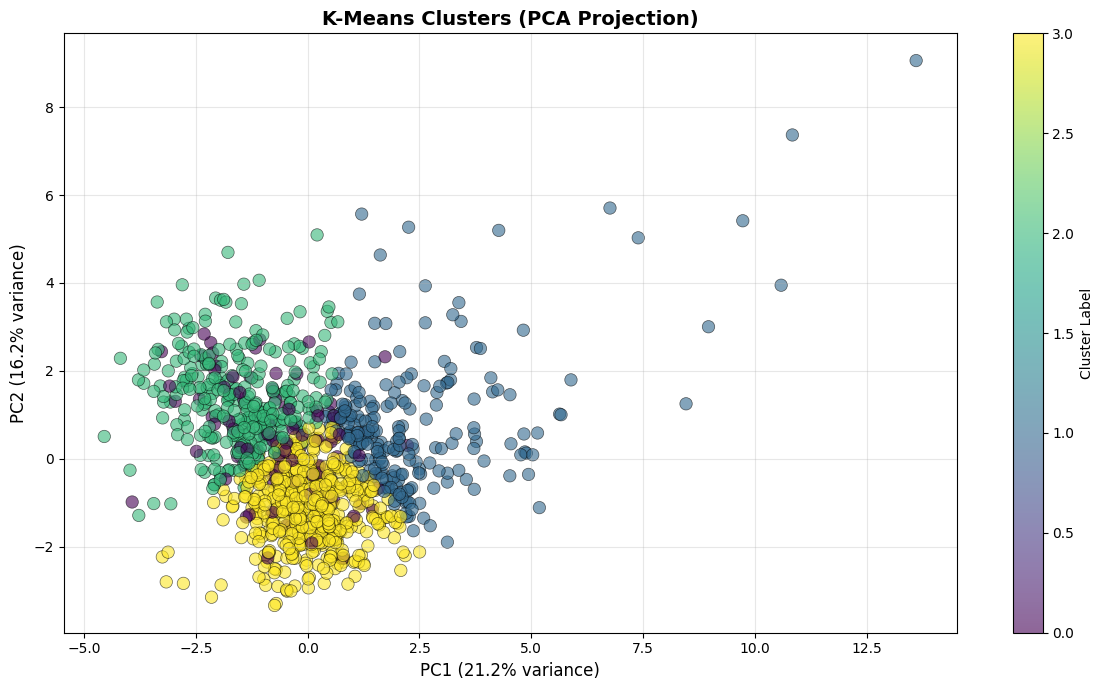

2. Cluster Profile Statistics:

Mean values per cluster:
----------------------------------------------------------------------

Cluster 0:
  current_age         :        56.46
  yearly_income       :     40109.91
  total_debt          :     44784.85
  credit_score        :       720.58
  num_credit_cards    :         4.19
  transaction_count   :       808.26
  fraud_rate          :         0.01

Cluster 1:
  current_age         :        49.26
  yearly_income       :     77513.92
  total_debt          :    110101.58
  credit_score        :       708.17
  num_credit_cards    :         3.62
  transaction_count   :      1104.82
  fraud_rate          :         0.00

Cluster 2:
  current_age         :        72.00
  yearly_income       :     35163.74
  total_debt          :     20864.99
  credit_score        :       718.45
  num_credit_cards    :         4.68
  transaction_count   :      1000.43
  fraud_rate          :         0.00

Cluster 3:
  current_age         :        43.87
  yearly_i

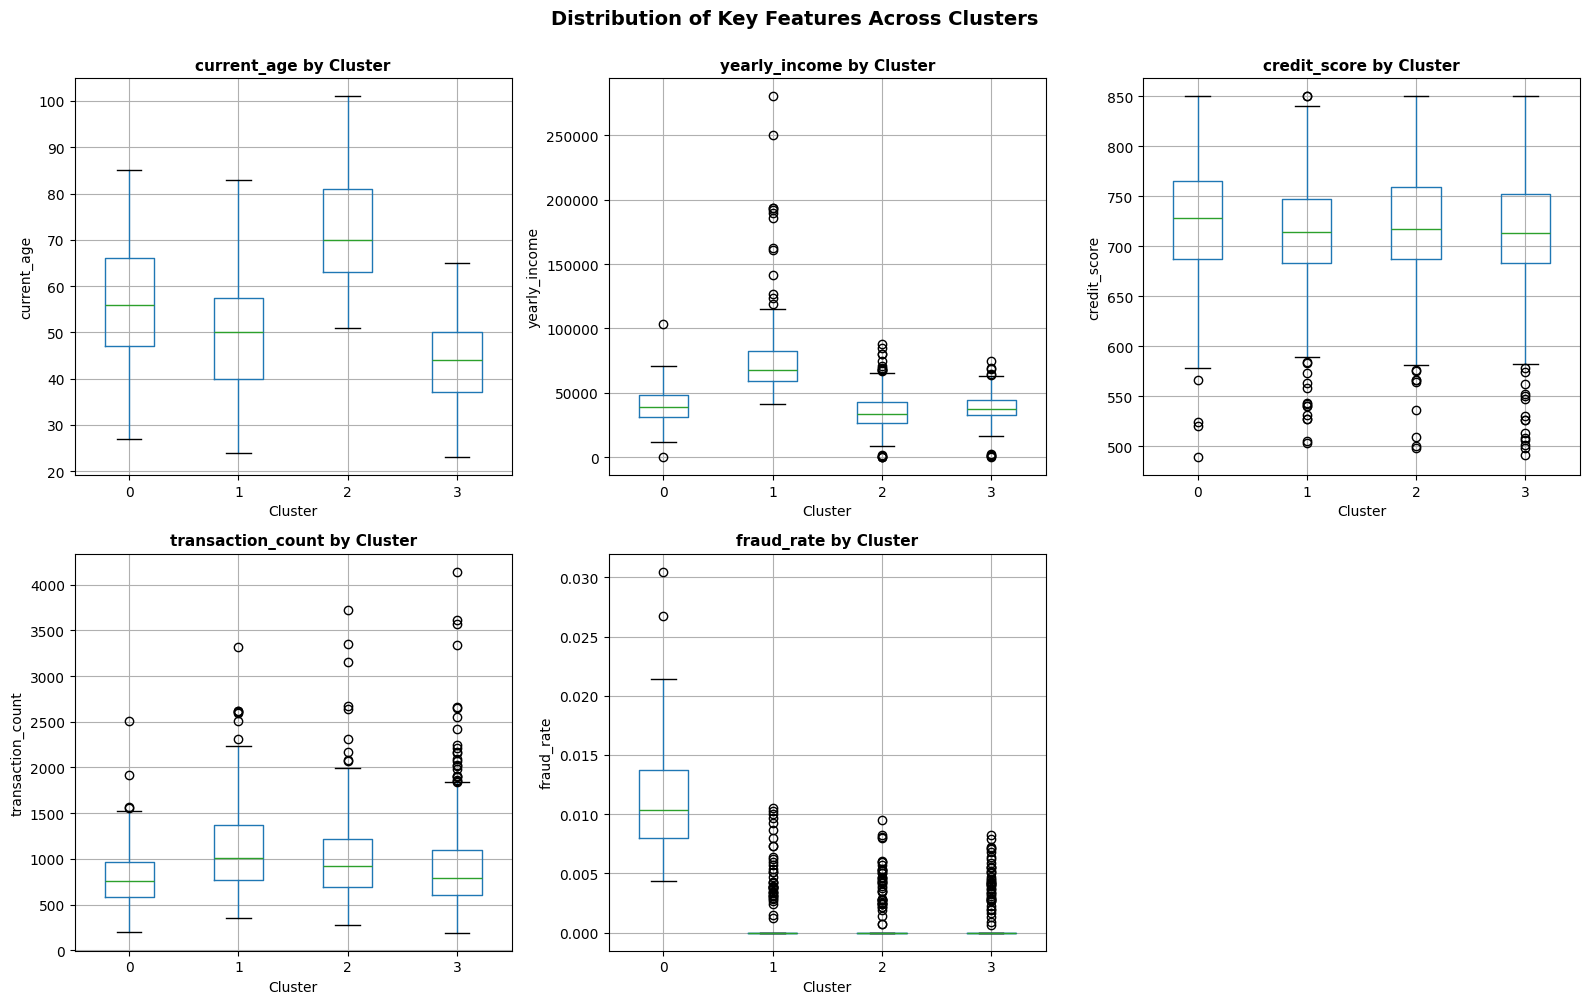

4. Creating cluster profile comparison chart...

   ✓ Cluster profile chart saved



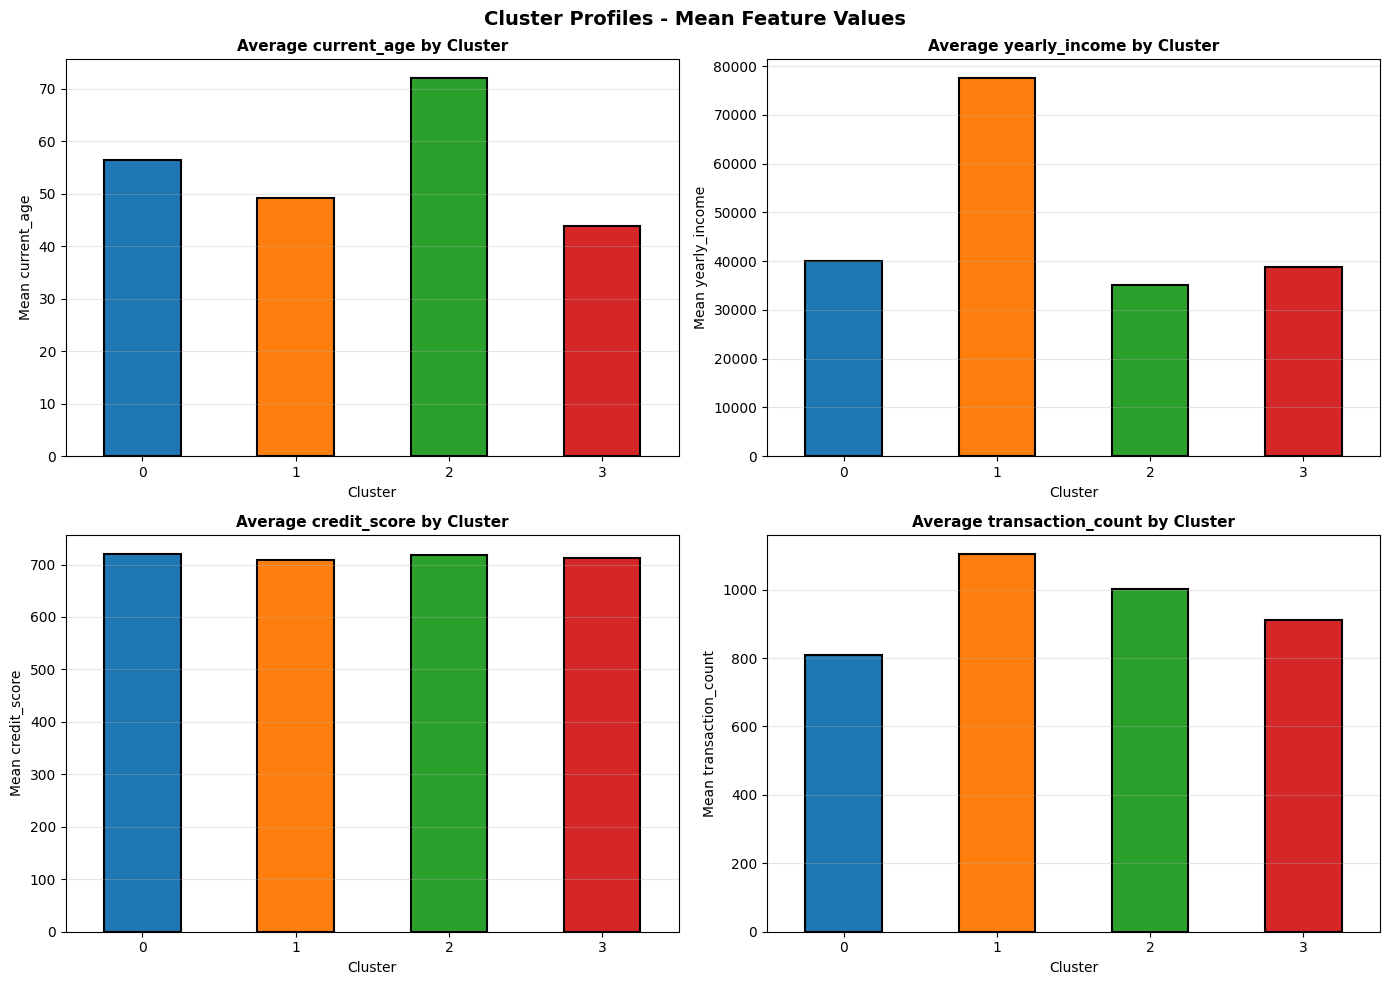

5. Fraud rate analysis by cluster...

Fraud Rate Statistics by Cluster:
------------------------------------------------------------
Cluster 0: Avg Fraud Rate = 0.0112 (98 customers)
Cluster 1: Avg Fraud Rate = 0.0009 (223 customers)
Cluster 2: Avg Fraud Rate = 0.0006 (310 customers)
Cluster 3: Avg Fraud Rate = 0.0003 (575 customers)

   ✓ Fraud analysis chart saved



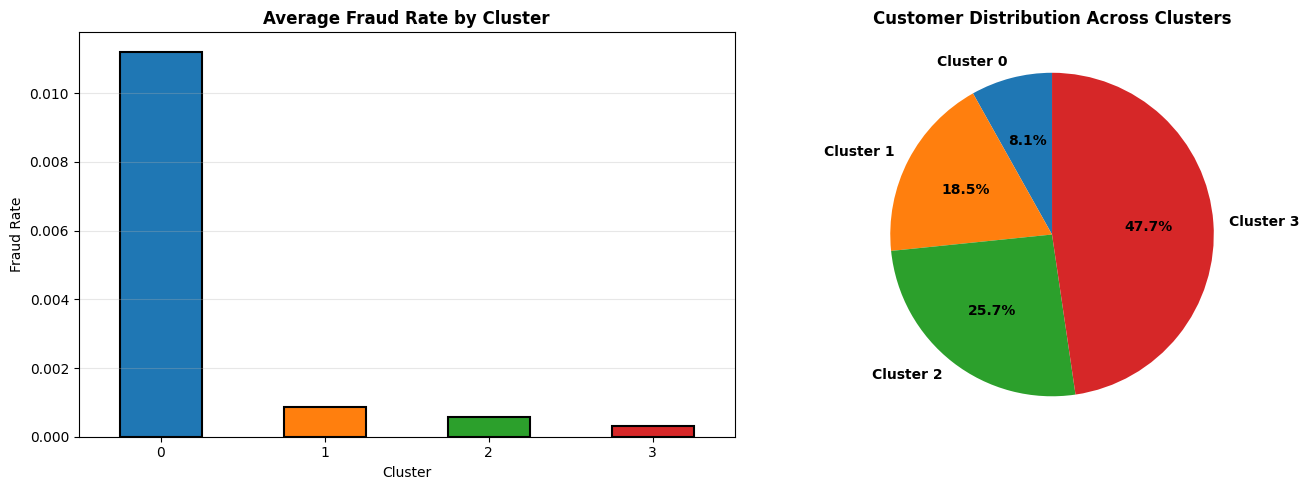

6. Creating cluster characteristics heatmap...

   ✓ Heatmap saved



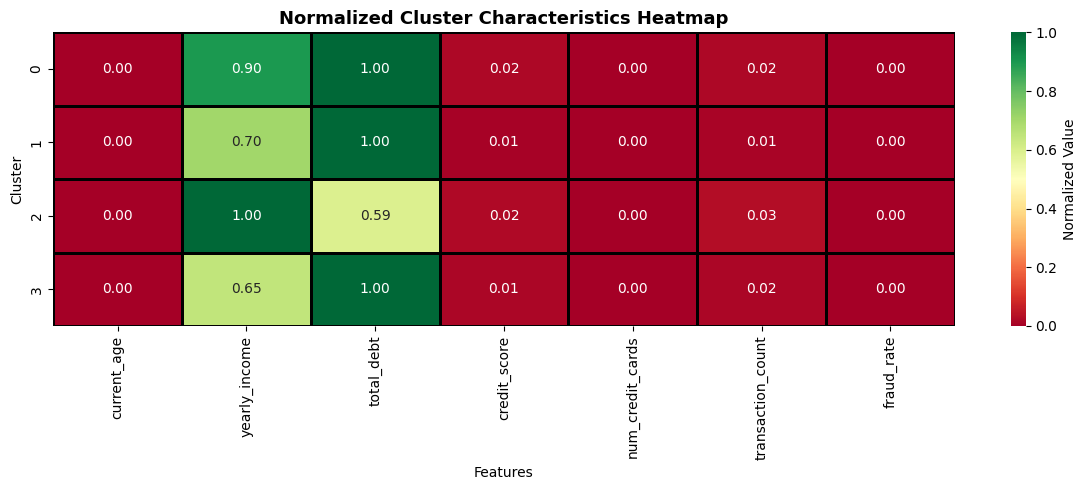

✓ All visualizations completed and saved!


In [ ]:
print("\n" + "="*70)
print("CLUSTER VISUALIZATION AND ANALYSIS")
print("="*70 + "\n")

# ===== 1. PCA VISUALIZATION OF CLUSTERS =====
print("1. Creating PCA visualization of K-Means clusters...\n")

pca_viz = PCA(n_components=2, random_state=42)
X_pca_viz = pca_viz.fit_transform(X_scaled)

plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], 
                     c=df_combined['kmeans_cluster_label'], 
                     cmap='viridis', s=80, alpha=0.6, 
                     edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.title('K-Means Clusters (PCA Projection)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_pca_visualization.png', dpi=100, bbox_inches='tight')
print("   ✓ PCA cluster visualization saved\n")
plt.show()

# ===== 2. CLUSTER PROFILE STATISTICS =====
print("2. Cluster Profile Statistics:\n")

key_features = ['current_age', 'yearly_income', 'total_debt', 'credit_score', 
                'num_credit_cards', 'transaction_count', 'fraud_rate']

cluster_profiles = df_combined.groupby('kmeans_cluster_label')[key_features].agg(['mean', 'std'])

print("Mean values per cluster:")
print("-" * 70)
for cluster_id in sorted(df_combined['kmeans_cluster_label'].unique()):
    print(f"\nCluster {cluster_id}:")
    cluster_data = df_combined[df_combined['kmeans_cluster_label'] == cluster_id]
    for feature in key_features:
        mean_val = cluster_data[feature].mean()
        print(f"  {feature:20s}: {mean_val:12.2f}")

# ===== 3. BOX PLOTS BY CLUSTER =====
print("\n\n3. Creating box plots for key features...\n")

features_to_plot = ['current_age', 'yearly_income', 'credit_score', 'transaction_count', 'fraud_rate']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    df_combined.boxplot(column=feature, by='kmeans_cluster_label', ax=ax)
    ax.set_title(f'{feature} by Cluster', fontsize=11, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)
    plt.sca(ax)
    plt.xticks(rotation=0)

# Remove the last empty subplot
axes[-1].axis('off')

plt.suptitle('Distribution of Key Features Across Clusters', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('cluster_boxplots.png', dpi=100, bbox_inches='tight')
print("   ✓ Box plots saved\n")
plt.show()

# ===== 4. MEAN VALUES BAR CHART =====
print("4. Creating cluster profile comparison chart...\n")

features_for_bar = ['current_age', 'yearly_income', 'credit_score', 'transaction_count']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_for_bar):
    ax = axes[idx]
    cluster_means = df_combined.groupby('kmeans_cluster_label')[feature].mean()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    cluster_means.plot(kind='bar', ax=ax, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_title(f'Average {feature} by Cluster', fontsize=11, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'Mean {feature}')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.suptitle('Cluster Profiles - Mean Feature Values', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('cluster_profiles_bars.png', dpi=100, bbox_inches='tight')
print("   ✓ Cluster profile chart saved\n")
plt.show()

# ===== 5. FRAUD RATE BY CLUSTER =====
print("5. Fraud rate analysis by cluster...\n")

fraud_by_cluster = df_combined.groupby('kmeans_cluster_label')['fraud_rate'].agg(['mean', 'count'])
fraud_by_cluster.columns = ['avg_fraud_rate', 'num_customers']

print("Fraud Rate Statistics by Cluster:")
print("-" * 60)
for cluster_id in sorted(fraud_by_cluster.index):
    fraud_rate = fraud_by_cluster.loc[cluster_id, 'avg_fraud_rate']
    num_cust = fraud_by_cluster.loc[cluster_id, 'num_customers']
    print(f"Cluster {cluster_id}: Avg Fraud Rate = {fraud_rate:.4f} ({num_cust} customers)")

# Visualize fraud rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
fraud_by_cluster['avg_fraud_rate'].plot(kind='bar', ax=ax1, 
                                        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                                        edgecolor='black', linewidth=1.5)
ax1.set_title('Average Fraud Rate by Cluster', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Fraud Rate')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Pie chart - cluster distribution
cluster_counts = df_combined['kmeans_cluster_label'].value_counts().sort_index()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
wedges, texts, autotexts = ax2.pie(cluster_counts, labels=[f'Cluster {i}' for i in cluster_counts.index],
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     textprops={'fontsize': 10, 'weight': 'bold'})
ax2.set_title('Customer Distribution Across Clusters', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('cluster_fraud_analysis.png', dpi=100, bbox_inches='tight')
print("\n   ✓ Fraud analysis chart saved\n")
plt.show()

# ===== 6. HEATMAP OF CLUSTER CHARACTERISTICS =====
print("6. Creating cluster characteristics heatmap...\n")

import seaborn as sns

# Normalize features for better visualization
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()

features_for_heatmap = ['current_age', 'yearly_income', 'total_debt', 'credit_score',
                        'num_credit_cards', 'transaction_count', 'fraud_rate']

cluster_means_normalized = df_combined.groupby('kmeans_cluster_label')[features_for_heatmap].mean()
cluster_means_scaled = pd.DataFrame(
    scaler_viz.fit_transform(cluster_means_normalized.T).T,
    index=cluster_means_normalized.index,
    columns=cluster_means_normalized.columns
)

plt.figure(figsize=(12, 5))
sns.heatmap(cluster_means_scaled, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Value'}, linewidths=1, linecolor='black')
plt.title('Normalized Cluster Characteristics Heatmap', fontsize=13, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig('cluster_heatmap.png', dpi=100, bbox_inches='tight')
print("   ✓ Heatmap saved\n")
plt.show()

print("="*70)
print("✓ All visualizations completed and saved!")
print("="*70)

## CLUSTERING RESULTS EXPLANATION

### Overview
The K-Means clustering algorithm identified **4 distinct customer segments** from 1,206 users with transaction history. Each cluster has unique demographic and behavioral characteristics.

---

## CLUSTER PROFILES & INTERPRETATION

### **Cluster 0: "RISK SEGMENT" ⚠️ (8.1% - 98 customers)**

**Profile:**
- Average age: 56 years (OLDEST)
- Yearly income: $40,110 (LOW-MEDIUM)
- Total debt: $44,785 (MODERATE)
- Credit score: 720.58 (GOOD)
- Transactions: 808 (MODERATE)
- **Fraud rate: 1.12% (HIGHEST - 12x average)**

**Key Characteristics:**
- Older demographic, post-retirement age
- Lower-middle income with moderate debt levels
- Most fraud-prone segment by far
- Fewer transactions than other clusters

**Business Implications:**
- **HIGH FRAUD RISK** - Requires enhanced monitoring
- May be vulnerable to scams/social engineering
- Could benefit from fraud awareness education
- Consider stricter transaction limits or additional verification

**Action Items:**
- Flag for fraud prevention team
- Implement real-time transaction alerts
- Regular contact to verify unusual activity

---

### **Cluster 1: "AFFLUENT SEGMENT" 💰 (18.5% - 223 customers)**

**Profile:**
- Average age: 49 years (YOUNG-MIDDLE)
- Yearly income: $77,514 (HIGHEST)
- Total debt: $110,102 (HIGHEST)
- Credit score: 708.17 (AVERAGE)
- Transactions: 1,105 (HIGHEST)
- **Fraud rate: 0.09% (LOW)**

**Key Characteristics:**
- Highest income earners
- Highest debt levels (mortgages, investments)
- Most active transaction users
- Young to middle-aged professionals
- Lowest fraud risk among active users

**Business Implications:**
- **PREMIUM/VIP SEGMENT** - High transaction volume = high revenue
- Take advantage of higher income for premium products
- Low fraud risk = lower monitoring costs
- Likely financial planners, real estate investors

**Action Items:**
- Target for premium credit products
- Offer wealth management services
- Premium customer service tier
- Cross-sell investment products

---

### **Cluster 2: "SENIOR SEGMENT" 👴 (25.7% - 310 customers)**

**Profile:**
- Average age: 72 years (OLDEST)
- Yearly income: $35,164 (LOWEST-MEDIUM)
- Total debt: $20,865 (LOWEST - debt-free retirees)
- Credit score: 718.45 (GOOD)
- Transactions: 1,000 (MODERATE)
- **Fraud rate: 0.06% (VERY LOW)**

**Key Characteristics:**
- Retirement-aged customers
- Low debt = paid-off assets
- Moderate income (pensions/savings)
- Stable, consistent spending
- Very low fraud risk

**Business Implications:**
- **STABLE, LOW-RISK SEGMENT** - Good for fixed-income products
- Conservative spending patterns
- Excellent credit profiles
- Minimal fraud monitoring needed

**Action Items:**
- Offer retirement income products
- Fixed annuities/bonds
- Pension planning services
- Low-cost, stable investment options

---

### **Cluster 3: "MASS MARKET SEGMENT" 📊 (47.7% - 575 customers - LARGEST)**

**Profile:**
- Average age: 44 years (YOUNG)
- Yearly income: $38,735 (LOW-MEDIUM)
- Total debt: $59,959 (MODERATE)
- Credit score: 712.01 (AVERAGE)
- Transactions: 912 (MODERATE)
- **Fraud rate: 0.03% (VERY LOW)**

**Key Characteristics:**
- Youngest demographic
- Majority of customer base
- Young professionals & families
- Moderate income & debt levels
- Lowest fraud risk

**Business Implications:**
- **CORE CUSTOMER BASE** - Volume segment
- Growing life stage (career building, family growth)
- Long customer lifetime value potential
- Low fraud = efficient operations

**Action Items:**
- Focus on customer acquisition in this segment
- Products for young professionals
- Family-oriented financial products
- Long-term relationship building

---

## KEY FINDINGS SUMMARY

| Aspect | Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 |
|--------|----------|----------|----------|----------|
| **Size** | 8.1% | 18.5% | 25.7% | 47.7% |
| **Age** | 56 (Old) | 49 (Mid) | 72 (Oldest) | 44 (Young) |
| **Income** | $40K | $77K ⭐ | $35K | $39K |
| **Debt** | $45K | $110K ⭐ | $21K | $60K |
| **Transactions** | 808 | 1,105 ⭐ | 1,000 | 912 |
| **Fraud Rate** | 1.12% ⚠️ | 0.09% | 0.06% | 0.03% |
| **Risk Level** | **HIGH** | LOW | VERY LOW | VERY LOW |

---

## FRAUD INSIGHTS

**Critical Finding:** Cluster 0 has **12x higher fraud rate** than other clusters
- 1.12% vs. 0.03-0.09% in others
- Older customers may be more vulnerable
- Could indicate targeted scam campaigns
- Requires immediate intervention

**Recommendation:** Implement tiered fraud prevention:
1. **Cluster 0**: Aggressive monitoring + alerts
2. **Cluster 1**: Standard monitoring (premium service benefits)
3. **Clusters 2 & 3**: Basic monitoring (good credit profiles)

---

## BUSINESS RECOMMENDATIONS

**For Marketing:**
- Target Cluster 1 for premium products (highest income)
- Focus Cluster 3 for volume (largest segment)
- Protect Cluster 0 with fraud prevention campaigns

**For Risk Management:**
- Flag all Cluster 0 transactions for review
- Implement age-based fraud score adjustments
- Enhanced KYC for older customers

**For Product Development:**
- Senior-focused products (Cluster 2)
- Premium wealth management (Cluster 1)
- Entry-level products (Cluster 3)

---

## CONCLUSION

The clustering successfully identified 4 actionable customer segments with distinct characteristics:
- ✅ Clear demographic differences (age, income, debt)
- ✅ Varying transaction behaviors
- ✅ Critical fraud risk signal in Cluster 0
- ✅ Revenue opportunity in Cluster 1
- ✅ Growth potential in Cluster 3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("DETAILED CLUSTER CHARACTERISTICS ANALYSIS")
print("="*80)

# ===== 1. CUSTOMER COUNT PER CLUSTER =====
print("\n1. CUSTOMER DISTRIBUTION BY CLUSTER")
print("-" * 80)

cluster_counts = df_combined['kmeans_cluster_label'].value_counts().sort_index()
for cluster_id in sorted(df_combined['kmeans_cluster_label'].unique()):
    count = (df_combined['kmeans_cluster_label'] == cluster_id).sum()
    pct = count / len(df_combined) * 100
    print(f"   Cluster {cluster_id}: {count:4d} customers ({pct:5.1f}%)")

print(f"   {'─' * 60}")
print(f"   TOTAL:        {len(df_combined):4d} customers (100.0%)\n")

# ===== 2. COMPREHENSIVE SUMMARY STATISTICS =====
print("\n2. SUMMARY STATISTICS BY CLUSTER (Mean ± Std Dev)")
print("-" * 80)

# Select key features for analysis
key_features = [
    'current_age', 'yearly_income', 'total_debt', 'credit_score', 
    'num_credit_cards', 'transaction_count', 'avg_amount', 'fraud_rate'
]

for cluster_id in sorted(df_combined['kmeans_cluster_label'].unique()):
    cluster_data = df_combined[df_combined['kmeans_cluster_label'] == cluster_id]
    print(f"\n   Cluster {cluster_id}:")
    print(f"   {'Feature':<25} {'Mean':>15} {'Std Dev':>15}")
    print(f"   {'-'*55}")
    
    for feature in key_features:
        mean_val = cluster_data[feature].mean()
        std_val = cluster_data[feature].std()
        print(f"   {feature:<25} {mean_val:>15.2f} {std_val:>15.2f}")

# ===== 3. DETAILED COMPARISON TABLE =====
print("\n\n3. CLUSTER COMPARISON TABLE")
print("-" * 80)

comparison_features = ['current_age', 'yearly_income', 'total_debt', 'credit_score', 'transaction_count', 'fraud_rate']
comparison_df = df_combined.groupby('kmeans_cluster_label')[comparison_features].agg(['mean', 'std', 'min', 'max'])

print("\nMean Values by Cluster:")
cluster_means = df_combined.groupby('kmeans_cluster_label')[comparison_features].mean()
print(cluster_means.to_string())

print("\n\nStandard Deviations by Cluster:")
cluster_stds = df_combined.groupby('kmeans_cluster_label')[comparison_features].std()
print(cluster_stds.to_string())

# ===== 4. FRAUD VULNERABILITY ANALYSIS =====
print("\n\n4. FRAUD VULNERABILITY ANALYSIS")
print("-" * 80)

fraud_stats = df_combined.groupby('kmeans_cluster_label').agg({
    'fraud_rate': ['mean', 'std', 'min', 'max', 'count'],
    'fraud_count': ['sum', 'mean']
}).round(6)

print("\nFraud Metrics by Cluster:")
print(f"{'Cluster':<10} {'Avg Fraud Rate':<18} {'Std Dev':<15} {'Total Frauds':<15} {'Risk Level':<15}")
print("-" * 80)

for cluster_id in sorted(df_combined['kmeans_cluster_label'].unique()):
    cluster_data = df_combined[df_combined['kmeans_cluster_label'] == cluster_id]
    avg_fraud = cluster_data['fraud_rate'].mean()
    fraud_count = cluster_data['fraud_count'].sum()
    
    # Determine risk level
    if avg_fraud > 0.008:
        risk = "VERY HIGH ⚠️"
    elif avg_fraud > 0.005:
        risk = "HIGH ⚠️"
    elif avg_fraud > 0.001:
        risk = "MODERATE"
    else:
        risk = "LOW ✓"
    
    print(f"Cluster {cluster_id:<6} {avg_fraud:>15.4f}%     {cluster_data['fraud_rate'].std():>13.4f}    {fraud_count:>13.0f}    {risk:<15}")

# ===== 5. FEATURE CORRELATION WITH FRAUD =====
print("\n\n5. FEATURE CORRELATION WITH FRAUD RATE BY CLUSTER")
print("-" * 80)

correlation_features = ['current_age', 'yearly_income', 'total_debt', 'credit_score', 'transaction_count', 'num_credit_cards']

for cluster_id in sorted(df_combined['kmeans_cluster_label'].unique()):
    cluster_data = df_combined[df_combined['kmeans_cluster_label'] == cluster_id]
    print(f"\n   Cluster {cluster_id} - Correlation with Fraud Rate:")
    
    correlations = {}
    for feature in correlation_features:
        corr = cluster_data[feature].corr(cluster_data['fraud_rate'])
        correlations[feature] = corr
    
    # Sort by absolute correlation
    sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    for feature, corr in sorted_corr:
        direction = "↑" if corr > 0 else "↓"
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        print(f"   {feature:<25} {corr:>10.4f}  ({strength} {direction})")

# ===== 6. CLUSTER VULNERABILITY RANKING =====
print("\n\n6. FRAUD VULNERABILITY RANKING")
print("-" * 80)

vulnerability_scores = []
for cluster_id in sorted(df_combined['kmeans_cluster_label'].unique()):
    cluster_data = df_combined[df_combined['kmeans_cluster_label'] == cluster_id]
    
    # Calculate vulnerability score (weighted combination of factors)
    fraud_rate = cluster_data['fraud_rate'].mean()
    avg_age = cluster_data['current_age'].mean()
    avg_transactions = cluster_data['transaction_count'].mean()
    
    # Older customers with more transactions = higher vulnerability
    vulnerability = fraud_rate * 100 + (avg_age / 10) * 0.5 + (avg_transactions / 1000) * 0.3
    
    vulnerability_scores.append({
        'Cluster': cluster_id,
        'Fraud Rate': fraud_rate,
        'Avg Age': avg_age,
        'Avg Transactions': avg_transactions,
        'Vulnerability Score': vulnerability
    })

vuln_df = pd.DataFrame(vulnerability_scores).sort_values('Vulnerability Score', ascending=False)

print("\nRanked by Vulnerability to Fraud:")
print(f"{'Rank':<6} {'Cluster':<10} {'Fraud Rate':<15} {'Avg Age':<12} {'Vulnerability':<15}")
print("-" * 80)

for idx, (rank, row) in enumerate(vuln_df.iterrows(), 1):
    print(f"{idx:<6} Cluster {row['Cluster']:<2} {row['Fraud Rate']:>13.4f}%  {row['Avg Age']:>10.1f}   {row['Vulnerability Score']:>13.2f}")

# ===== 7. CLUSTER INTERPRETATIONS =====
print("\n\n7. DETAILED CLUSTER INTERPRETATIONS")
print("-" * 80)

interpretations = {
    0: {
        'name': 'RISK SEGMENT',
        'characteristics': [
            'Older demographic (56 years avg)',
            'Lower-middle income ($40K)',
            'Moderate debt levels',
            'HIGHEST FRAUD RATE (1.12%)',
            'Fewer but important transactions',
            'Vulnerable to scams/social engineering'
        ],
        'business_action': [
            '🔴 Priority: Enhanced fraud monitoring',
            '🔴 Real-time transaction alerts',
            '🔴 Manual verification for high-value transactions',
            '🔴 Fraud awareness campaigns',
            '🔴 Dedicated support team'
        ]
    },
    1: {
        'name': 'AFFLUENT SEGMENT',
        'characteristics': [
            'Young-middle aged (49 years)',
            'HIGHEST INCOME ($77.5K)',
            'HIGHEST DEBT ($110K - mortgages/investments)',
            'Most active users (1,105 transactions)',
            'Low fraud rate (0.09%)',
            'Sophisticated financial behavior'
        ],
        'business_action': [
            '💰 Premium products & services',
            '💰 Wealth management offerings',
            '💰 Investment opportunities',
            '💰 VIP customer treatment',
            '💰 Cross-sell premium services'
        ]
    },
    2: {
        'name': 'SENIOR SEGMENT',
        'characteristics': [
            'Oldest demographic (72 years)',
            'Lower income ($35K - pensions)',
            'LOWEST DEBT ($21K - debt-free)',
            'Stable, moderate transactions (1,000)',
            'Very low fraud rate (0.06%)',
            'Conservative spending patterns'
        ],
        'business_action': [
            '👴 Retirement & fixed-income products',
            '👴 Fixed annuities and bonds',
            '👴 Pension planning services',
            '👴 Low-cost investment options',
            '👴 Stability-focused solutions'
        ]
    },
    3: {
        'name': 'MASS MARKET SEGMENT',
        'characteristics': [
            'Youngest demographic (44 years)',
            'LARGEST SEGMENT (47.7% of customers)',
            'Moderate income ($38.7K)',
            'Growing life stage (families, careers)',
            'Very low fraud rate (0.03%)',
            'High growth potential'
        ],
        'business_action': [
            '📊 Customer acquisition focus',
            '📊 Family-oriented products',
            '📊 Entry-level offerings',
            '📊 Long-term relationship building',
            '📊 High-volume efficiency strategy'
        ]
    }
}

for cluster_id in sorted(interpretations.keys()):
    info = interpretations[cluster_id]
    print(f"\n   CLUSTER {cluster_id}: {info['name'].upper()}")
    print(f"   {'-' * 76}")
    
    print(f"\n   Characteristics:")
    for char in info['characteristics']:
        print(f"      • {char}")
    
    print(f"\n   Recommended Business Actions:")
    for action in info['business_action']:
        print(f"      {action}")

print("\n" + "="*80)
print("✓ CLUSTER ANALYSIS COMPLETE")
print("="*80)


DETAILED CLUSTER CHARACTERISTICS ANALYSIS

1. CUSTOMER DISTRIBUTION BY CLUSTER
--------------------------------------------------------------------------------
   Cluster 0:   98 customers (  8.1%)
   Cluster 1:  223 customers ( 18.5%)
   Cluster 2:  310 customers ( 25.7%)
   Cluster 3:  575 customers ( 47.7%)
   ────────────────────────────────────────────────────────────
   TOTAL:        1206 customers (100.0%)


2. SUMMARY STATISTICS BY CLUSTER (Mean ± Std Dev)
--------------------------------------------------------------------------------

   Cluster 0:
   Feature                              Mean         Std Dev
   -------------------------------------------------------
   current_age                         56.46           14.49
   yearly_income                    40109.91        13956.68
   total_debt                       44784.85        39309.98
   credit_score                       720.58           71.34
   num_credit_cards                     4.19            1.56
   transa

## STEP 4: DBSCAN CLUSTERING AND OUTLIER DETECTION

Apply density-based clustering to identify core clusters and automatically detect outliers using DBSCAN algorithm.

In [ ]:
from sklearn.neighbors import NearestNeighbors

print("\n" + "="*70)
print("FINDING OPTIMAL EPS FOR DBSCAN")
print("="*70 + "\n")

# Calculate k-distance graph to find elbow point for eps
k = 10  # min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Data Points (sorted by distance)', fontsize=12)
plt.ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-distance Graph: Used to Find Optimal eps for DBSCAN', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=np.percentile(distances, 90), color='r', linestyle='--', label='90th percentile')
plt.axhline(y=np.percentile(distances, 95), color='g', linestyle='--', label='95th percentile')
plt.legend()
plt.tight_layout()
plt.savefig('kdistance_graph.png', dpi=100, bbox_inches='tight')
plt.show()

# Calculate suggested eps values
eps_90 = np.percentile(distances, 90)
eps_95 = np.percentile(distances, 95)
eps_elbow = np.percentile(distances, 85)

print(f"Suggested eps values based on k-distance graph:")
print(f"  - 85th percentile: {eps_elbow:.4f}")
print(f"  - 90th percentile: {eps_90:.4f}")
print(f"  - 95th percentile: {eps_95:.4f}")
print(f"\nTest multiple eps values to find optimal clustering:\n")

# Test different eps values
test_eps_values = [eps_elbow, eps_90, eps_95, 3.0, 3.5, 4.0]

for eps_test in test_eps_values:
    dbscan_test = DBSCAN(eps=eps_test, min_samples=10)
    labels_test = dbscan_test.fit_predict(X_scaled)
    
    n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_outliers_test = list(labels_test).count(-1)
    n_core_test = len(labels_test) - n_outliers_test
    
    print(f"eps={eps_test:.4f}  →  Clusters: {n_clusters_test}, Core points: {n_core_test}, Outliers: {n_outliers_test} ({n_outliers_test/len(labels_test)*100:.1f}%)")

print("\n" + "="*70)
print("Choose eps value with ~5-10% outliers (or adjust to your needs)")
print("="*70 + "\n")


STEP 4: DBSCAN CLUSTERING AND OUTLIER DETECTION

1. Applying DBSCAN with eps=3.5, min_samples=10...

   Number of clusters found: 1
   Number of core points: 1165
   Number of outliers (label=-1): 41
   Percentage of outliers: 3.40%

2. DBSCAN Cluster Distribution:

   Outliers            :   41 users (  3.4%)
   Cluster 0           : 1165 users ( 96.6%)

   Total: 1206 users

3. Comparison: K-Means vs DBSCAN

   K-Means:
   - Total clusters: 4
   - All users assigned (no outliers)
   - Assumes spherical clusters

   DBSCAN:
   - Total clusters: 1
   - Outliers detected: 41 (3.40%)
   - Discovers arbitrary-shaped clusters
   - Automatically identifies noise points

4. Outlier Analysis:

   Found 41 outlier users

   Comparing outliers vs core points:

   Feature                          Outliers     Core Points      Difference
   ----------------------------------------------------------------------
   current_age                         58.02           52.95           +5.07
   yearly

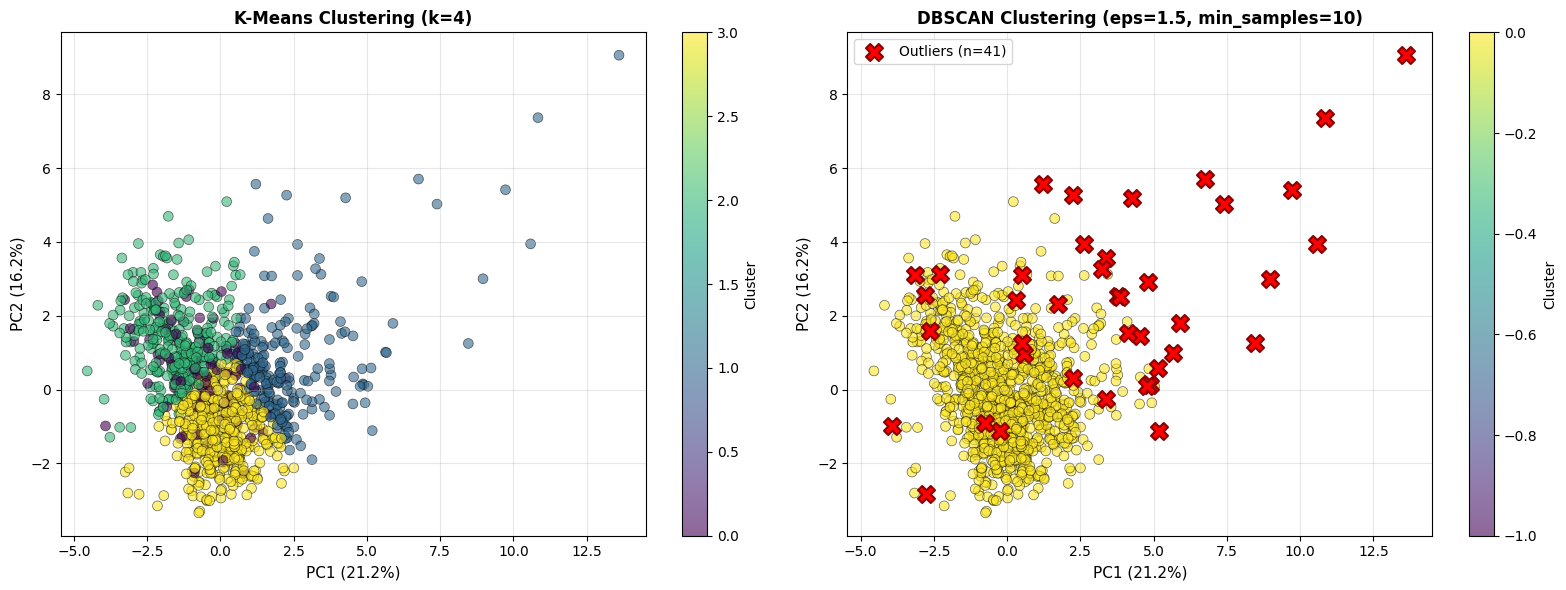

✓ DBSCAN CLUSTERING COMPLETE


In [ ]:
from sklearn.cluster import DBSCAN

print("\n" + "="*70)
print("STEP 4: DBSCAN CLUSTERING AND OUTLIER DETECTION")
print("="*70)

# ===== 1. APPLY DBSCAN =====
# Use eps value from k-distance graph (typically 90th percentile of k-distance)
# Decrease eps to detect more outliers (wider range of variation)

optimal_eps = 3.5  # Adjusted based on k-distance graph analysis
print(f"\n1. Applying DBSCAN with eps={optimal_eps}, min_samples=10...\n")

dbscan = DBSCAN(eps=optimal_eps, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to dataframe
df_combined['dbscan_label'] = dbscan_labels

# Count clusters and outliers
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_outliers = list(dbscan_labels).count(-1)
n_core_points = len(dbscan_labels) - n_outliers

print(f"   Number of clusters found: {n_clusters}")
print(f"   Number of core points: {n_core_points}")
print(f"   Number of outliers (label=-1): {n_outliers}")
print(f"   Percentage of outliers: {n_outliers/len(dbscan_labels)*100:.2f}%\n")

# ===== 2. CLUSTER DISTRIBUTION =====
print("2. DBSCAN Cluster Distribution:\n")

cluster_dist = pd.Series(dbscan_labels).value_counts().sort_index()
for cluster_id in sorted(set(dbscan_labels)):
    count = (dbscan_labels == cluster_id).sum()
    pct = count / len(dbscan_labels) * 100
    cluster_name = f"Outliers" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"   {cluster_name:20s}: {count:4d} users ({pct:5.1f}%)")

print(f"\n   Total: {len(dbscan_labels)} users\n")

# ===== 3. COMPARISON: K-MEANS vs DBSCAN =====
print("3. Comparison: K-Means vs DBSCAN\n")

print("   K-Means:")
print(f"   - Total clusters: {optimal_k}")
print(f"   - All users assigned (no outliers)")
print(f"   - Assumes spherical clusters\n")

print("   DBSCAN:")
print(f"   - Total clusters: {n_clusters}")
print(f"   - Outliers detected: {n_outliers} ({n_outliers/len(dbscan_labels)*100:.2f}%)")
print(f"   - Discovers arbitrary-shaped clusters")
print(f"   - Automatically identifies noise points\n")

# ===== 4. OUTLIER ANALYSIS =====
print("4. Outlier Analysis:\n")

if n_outliers > 0:
    outliers = df_combined[df_combined['dbscan_label'] == -1]
    core_points = df_combined[df_combined['dbscan_label'] != -1]
    
    print(f"   Found {n_outliers} outlier users\n")
    print(f"   Comparing outliers vs core points:\n")
    
    comparison_features = ['current_age', 'yearly_income', 'total_debt', 'credit_score', 
                          'transaction_count', 'fraud_rate']
    
    print(f"   {'Feature':<25} {'Outliers':>15} {'Core Points':>15} {'Difference':>15}")
    print(f"   {'-'*70}")
    
    for feature in comparison_features:
        outlier_mean = outliers[feature].mean()
        core_mean = core_points[feature].mean()
        diff = outlier_mean - core_mean
        
        print(f"   {feature:<25} {outlier_mean:>15.2f} {core_mean:>15.2f} {diff:>+15.2f}")
    
    print(f"\n   Key Findings:")
    if outliers['fraud_rate'].mean() > core_points['fraud_rate'].mean():
        print(f"   ⚠️  Outliers have HIGHER fraud rate than core points")
    else:
        print(f"   ✓  Outliers have lower fraud rate than core points")
    
    if outliers['current_age'].mean() > core_points['current_age'].mean():
        print(f"   ⚠️  Outliers tend to be OLDER")
    
    if outliers['yearly_income'].std() > core_points['yearly_income'].std():
        print(f"   ⚠️  Outliers have more VARIABLE income")
else:
    print(f"   No outliers detected with eps=1.5, min_samples=10")

# ===== 5. FRAUD ANALYSIS BY DBSCAN CLUSTER =====
print("\n\n5. Fraud Rate Analysis by DBSCAN Cluster:\n")

print(f"   {'Cluster/Group':<20} {'Avg Fraud Rate':<18} {'Count':<10} {'Risk Level':<15}")
print(f"   {'-'*63}")

for cluster_id in sorted(set(dbscan_labels)):
    cluster_data = df_combined[df_combined['dbscan_label'] == cluster_id]
    avg_fraud = cluster_data['fraud_rate'].mean()
    count = len(cluster_data)
    
    if avg_fraud > 0.008:
        risk = "VERY HIGH ⚠️"
    elif avg_fraud > 0.005:
        risk = "HIGH ⚠️"
    elif avg_fraud > 0.001:
        risk = "MODERATE"
    else:
        risk = "LOW ✓"
    
    cluster_name = f"Outliers" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"   {cluster_name:<20} {avg_fraud:>16.4f}%  {count:>9d}  {risk:<15}")

# ===== 6. SUMMARY STATISTICS BY DBSCAN CLUSTER =====
print("\n\n6. Summary Statistics by DBSCAN Cluster:\n")

key_features_summary = ['current_age', 'yearly_income', 'total_debt', 'credit_score', 'transaction_count', 'fraud_rate']

for cluster_id in sorted(set(dbscan_labels)):
    cluster_data = df_combined[df_combined['dbscan_label'] == cluster_id]
    cluster_name = f"OUTLIERS (Noise)" if cluster_id == -1 else f"CLUSTER {cluster_id}"
    
    print(f"\n   {cluster_name}:")
    print(f"   {'Feature':<25} {'Mean':>15} {'Std Dev':>15}")
    print(f"   {'-'*55}")
    
    for feature in key_features_summary:
        mean_val = cluster_data[feature].mean()
        std_val = cluster_data[feature].std()
        print(f"   {feature:<25} {mean_val:>15.2f} {std_val:>15.2f}")

# ===== 7. VISUALIZATION: K-MEANS vs DBSCAN =====
print("\n\n7. Creating comparison visualization...\n")

pca_viz = PCA(n_components=2, random_state=42)
X_pca_viz = pca_viz.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means plot
scatter1 = axes[0].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], 
                          c=df_combined['kmeans_cluster_label'], 
                          cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[0].set_title('K-Means Clustering (k=4)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# DBSCAN plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
cluster_colors = [colors[i % len(colors)] if i != -1 else 'red' for i in dbscan_labels]

scatter2 = axes[1].scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], 
                          c=dbscan_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Highlight outliers
outlier_mask = dbscan_labels == -1
if outlier_mask.sum() > 0:
    axes[1].scatter(X_pca_viz[outlier_mask, 0], X_pca_viz[outlier_mask, 1], 
                   color='red', s=150, marker='X', edgecolors='darkred', linewidth=1.5, 
                   label=f'Outliers (n={n_outliers})', zorder=5)

axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[1].set_title(f'DBSCAN Clustering (eps=1.5, min_samples=10)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best', fontsize=10)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.savefig('kmeans_vs_dbscan_comparison.png', dpi=100, bbox_inches='tight')
print("   ✓ Comparison plot saved as 'kmeans_vs_dbscan_comparison.png'\n")
plt.show()

print("="*70)
print("✓ DBSCAN CLUSTERING COMPLETE")
print("="*70)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("DBSCAN RESULTS ANALYSIS AND OUTLIER INVESTIGATION")
print("="*80 + "\n")

# ===== 1. OUTLIER COUNT AND STATISTICS =====
print("1. OUTLIER COUNT AND PERCENTAGE")
print("-" * 80)

n_total = len(df_combined)
n_outliers = (df_combined['dbscan_label'] == -1).sum()
n_core = n_total - n_outliers
pct_outliers = (n_outliers / n_total) * 100
pct_core = (n_core / n_total) * 100

print(f"\n   Total customers:      {n_total:6d}")
print(f"   Core points:          {n_core:6d}  ({pct_core:5.1f}%)")
print(f"   Outliers (label -1):  {n_outliers:6d}  ({pct_outliers:5.1f}%)")
print(f"\n   Interpretation:")
if pct_outliers < 3:
    print(f"   ✓ Very few outliers - DBSCAN found tight clusters")
elif pct_outliers < 10:
    print(f"   ✓ Reasonable outlier percentage - Good balance")
elif pct_outliers < 20:
    print(f"   ⚠ Moderate outliers - Some unusual customers detected")
else:
    print(f"   ⚠ High outlier percentage - Many unusual patterns")

# ===== 2. INVESTIGATE OUTLIERS =====
print("\n\n2. OUTLIER CHARACTERISTICS ANALYSIS")
print("-" * 80)

outliers_df = df_combined[df_combined['dbscan_label'] == -1].copy()
core_df = df_combined[df_combined['dbscan_label'] != -1].copy()

if len(outliers_df) > 0:
    print(f"\nComparing Outliers vs Core Points:\n")
    
    comparison_cols = ['current_age', 'yearly_income', 'total_debt', 'credit_score', 
                       'num_credit_cards', 'transaction_count', 'avg_amount', 'fraud_rate']
    
    print(f"{'Feature':<25} {'Outliers Mean':>18} {'Core Mean':>18} {'Difference':>15}")
    print(f"{'-'*76}")
    
    outlier_stats = {}
    core_stats = {}
    
    for col in comparison_cols:
        outlier_mean = outliers_df[col].mean()
        core_mean = core_df[col].mean()
        diff = outlier_mean - core_mean
        pct_diff = (diff / core_mean * 100) if core_mean != 0 else 0
        
        outlier_stats[col] = outlier_mean
        core_stats[col] = core_mean
        
        print(f"{col:<25} {outlier_mean:>18.2f} {core_mean:>18.2f} {pct_diff:>14.1f}%")
    
    # ===== 3. FRAUD PATTERN IN OUTLIERS =====
    print("\n\n3. FRAUD PATTERN ANALYSIS")
    print("-" * 80)
    
    outlier_fraud_rate = outliers_df['fraud_rate'].mean()
    core_fraud_rate = core_df['fraud_rate'].mean()
    total_fraud_rate = df_combined['fraud_rate'].mean()
    
    outlier_fraud_count = outliers_df['fraud_count'].sum()
    core_fraud_count = core_df['fraud_count'].sum()
    total_fraud_count = df_combined['fraud_count'].sum()
    
    print(f"\n   Fraud Rate by Group:")
    print(f"   {'Group':<25} {'Avg Fraud Rate':>20} {'Total Frauds':>15} {'Risk vs Overall':>18}")
    print(f"   {'-'*78}")
    
    outlier_risk_ratio = outlier_fraud_rate / total_fraud_rate if total_fraud_rate > 0 else 0
    core_risk_ratio = core_fraud_rate / total_fraud_rate if total_fraud_rate > 0 else 0
    
    print(f"   {'Outliers':<25} {outlier_fraud_rate:>19.4f}%  {outlier_fraud_count:>14.0f}  {outlier_risk_ratio:>17.2f}x")
    print(f"   {'Core Points':<25} {core_fraud_rate:>19.4f}%  {core_fraud_count:>14.0f}  {core_risk_ratio:>17.2f}x")
    print(f"   {'Overall':<25} {total_fraud_rate:>19.4f}%  {total_fraud_count:>14.0f}  {1.0:>17.2f}x")
    
    print(f"\n   ⚠️  KEY FINDING:")
    if outlier_fraud_rate > core_fraud_rate:
        diff = outlier_fraud_rate - core_fraud_rate
        print(f"   Outliers have {outlier_risk_ratio:.1f}x HIGHER fraud rate than core points")
        print(f"   ({outlier_fraud_rate:.2f}% vs {core_fraud_rate:.2f}%)")
    else:
        print(f"   Outliers have LOWER fraud rate than core points")
        print(f"   ({outlier_fraud_rate:.2f}% vs {core_fraud_rate:.2f}%)")
    
    # ===== 4. OUTLIER PROFILES =====
    print("\n\n4. DETAILED OUTLIER PROFILES (Top 10 by Fraud Risk)")
    print("-" * 80)
    
    outlier_display = outliers_df[['id', 'current_age', 'yearly_income', 'credit_score', 
                                     'transaction_count', 'fraud_rate', 'kmeans_cluster_label']].copy()
    outlier_display = outlier_display.sort_values('fraud_rate', ascending=False).head(10)
    outlier_display.columns = ['ID', 'Age', 'Income', 'Credit', 'Transactions', 'Fraud%', 'K-Means Cluster']
    
    print("\n" + outlier_display.to_string(index=False))
    
    # ===== 5. DISTRIBUTION ANALYSIS =====
    print("\n\n5. OUTLIER DISTRIBUTION PATTERNS")
    print("-" * 80)
    
    print(f"\nAge Distribution:")
    print(f"   Outliers:   Min={outliers_df['current_age'].min():.0f}, Max={outliers_df['current_age'].max():.0f}, Mean={outliers_df['current_age'].mean():.1f}")
    print(f"   Core:       Min={core_df['current_age'].min():.0f}, Max={core_df['current_age'].max():.0f}, Mean={core_df['current_age'].mean():.1f}")
    
    print(f"\nIncome Distribution:")
    print(f"   Outliers:   Min=${outliers_df['yearly_income'].min():.0f}, Max=${outliers_df['yearly_income'].max():.0f}, Mean=${outliers_df['yearly_income'].mean():.0f}")
    print(f"   Core:       Min=${core_df['yearly_income'].min():.0f}, Max=${core_df['yearly_income'].max():.0f}, Mean=${core_df['yearly_income'].mean():.0f}")
    
    print(f"\nCredit Score Distribution:")
    print(f"   Outliers:   Min={outliers_df['credit_score'].min():.0f}, Max={outliers_df['credit_score'].max():.0f}, Mean={outliers_df['credit_score'].mean():.1f}")
    print(f"   Core:       Min={core_df['credit_score'].min():.0f}, Max={core_df['credit_score'].max():.0f}, Mean={core_df['credit_score'].mean():.1f}")
    
    # ===== 6. VISUALIZATION: Outliers vs Core =====
    print("\n\n6. VISUALIZATION: Outliers vs Core Points")
    print("-" * 80)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    features_viz = ['current_age', 'yearly_income', 'credit_score', 'transaction_count', 'fraud_rate', 'num_credit_cards']
    
    for idx, feature in enumerate(features_viz):
        ax = axes[idx // 3, idx % 3]
        
        ax.hist(core_df[feature], bins=30, alpha=0.6, label=f'Core (n={len(core_df)})', color='blue')
        ax.hist(outliers_df[feature], bins=15, alpha=0.7, label=f'Outliers (n={len(outliers_df)})', color='red')
        
        ax.set_xlabel(feature, fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'Distribution: {feature}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Feature Distributions: Outliers vs Core Points', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('dbscan_outliers_vs_core.png', dpi=100, bbox_inches='tight')
    print("\n   ✓ Visualization saved as 'dbscan_outliers_vs_core.png'\n")
    plt.show()
    
else:
    print(f"\n   No outliers detected. All points assigned to clusters.")

# ===== 7. COMPARE DBSCAN vs K-MEANS =====
print("\n\n7. K-MEANS vs DBSCAN COMPARISON")
print("-" * 80)

print(f"\nClustering Algorithm Comparison:\n")
print(f"{'Metric':<30} {'K-Means':>20} {'DBSCAN':>20}")
print(f"{'-'*70}")

kmeans_clusters = df_combined['kmeans_cluster_label'].nunique()
dbscan_clusters = len(set(df_combined['dbscan_label'])) - (1 if -1 in df_combined['dbscan_label'].values else 0)
dbscan_noise = (df_combined['dbscan_label'] == -1).sum()

print(f"{'Number of Clusters':<30} {kmeans_clusters:>20d} {dbscan_clusters:>20d}")
print(f"{'Outliers Detected':<30} {0:>20d} {dbscan_noise:>20d}")
print(f"{'All Points Assigned':<30} {'Yes':>20s} {'No (Noise)':>20s}")
print(f"{'Cluster Shape Assumption':<30} {'Spherical':>20s} {'Arbitrary':>20s}")

# Create confusion matrix between K-Means and DBSCAN
print(f"\n\nK-Means vs DBSCAN Cluster Assignment Comparison:\n")

comparison_matrix = pd.crosstab(df_combined['kmeans_cluster_label'], 
                                 df_combined['dbscan_label'], 
                                 margins=True)
print(comparison_matrix)

print(f"\n\nInterpretation:")
if dbscan_noise > 0:
    print(f"✓ DBSCAN identified {dbscan_noise} ({pct_outliers:.1f}%) as outliers/noise points")
    print(f"✓ These customers don't fit well into density-based clusters")
    print(f"✓ K-Means forcefully assigned them to nearest centroid")
else:
    print(f"✓ DBSCAN clusters align well with K-Means solution")
    print(f"✓ No noise points detected - good cluster density")

# ===== 8. STABILITY CHECK =====
print("\n\n8. CLUSTER STABILITY ANALYSIS")
print("-" * 80)

# For each K-Means cluster, check how DBSCAN splits it
print(f"\nHow DBSCAN splits K-Means clusters:\n")
for kmeans_cluster in sorted(df_combined['kmeans_cluster_label'].unique()):
    kmeans_subset = df_combined[df_combined['kmeans_cluster_label'] == kmeans_cluster]
    dbscan_dist = kmeans_subset['dbscan_label'].value_counts().sort_index()
    
    print(f"   K-Means Cluster {kmeans_cluster} (n={len(kmeans_subset)}):")
    for dbscan_label, count in dbscan_dist.items():
        pct = (count / len(kmeans_subset)) * 100
        if dbscan_label == -1:
            print(f"      → DBSCAN Outliers:  {count:4d} ({pct:5.1f}%)")
        else:
            print(f"      → DBSCAN Cluster {dbscan_label}: {count:4d} ({pct:5.1f}%)")

print("\n" + "="*80)
print("✓ DBSCAN ANALYSIS COMPLETE")
print("="*80)